In [1]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr, norm, normaltest
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model



In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
len(df.corr())

38

In [4]:
corrs = df.corr()
corrs.SalePrice.sort_values(ascending=False)[:11]
# top 10 correlation coefficients of all the numerical columns, also there's 38 numerical columns and 43 categorical columns

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

In [5]:
topcorrcol = df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 
                '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearRemodAdd', 'YearBuilt']]
topcorrcol.corr().corr().style.background_gradient(cmap='coolwarm')

# 'TotalBsmtSF' and '1stFlrSF' have a .82 correlation. (Bigger basement means bigger 1st floor?)
# I keep TotalBsmtSf because it has a slightly higher correlation with Sale Price.

# 'YearBuilt' and 'YearRemodAdd' have huge VIFs (above 8k). The other columns' VIFs are below 65.
# I keep YearBuilt because it has a slightly higher correlation with Sale Price.

# 'GarageCars' and 'GarageArea' have a .88 correlation. (Bigger garage means more cars can fit in it?)
# I keep GarageCars because it has a slightly higher correlation with Sale Price.

# 'TotRmsAbvGrd' and 'GrLivArea' have a .825 correlation. (Bigger living area means more number of rooms?)
# I keep GrLivArea because it has a significantly higher correlation with Sale Price.

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearRemodAdd,YearBuilt
SalePrice,1.000000,0.728774,0.415567,0.272765,0.281923,0.296673,0.282398,0.050809,0.179674,-0.073784,-0.040764
OverallQual,0.728774,1.000000,0.059480,0.275165,0.205571,0.070656,-0.089620,0.098485,-0.128654,0.295338,0.329727
GrLivArea,0.415567,0.059480,1.000000,-0.211904,-0.172013,-0.036437,0.264699,0.418221,0.928423,-0.592394,-0.791070
GarageCars,0.272765,0.275165,-0.211904,1.000000,0.949273,-0.067818,-0.134101,-0.167662,-0.285214,0.007716,0.298617
GarageArea,0.281923,0.205571,-0.172013,0.949273,1.000000,0.104649,0.051515,-0.295580,-0.275365,-0.118062,0.181298
TotalBsmtSF,0.296673,0.070656,-0.036437,-0.067818,0.104649,1.000000,0.886944,-0.509664,-0.237195,-0.392880,-0.156999
1stFlrSF,0.282398,-0.089620,0.264699,-0.134101,0.051515,0.886944,1.000000,-0.359865,0.081402,-0.609890,-0.467773
FullBath,0.050809,0.098485,0.418221,-0.167662,-0.295580,-0.509664,-0.359865,1.000000,0.431560,-0.018301,-0.088788
TotRmsAbvGrd,0.179674,-0.128654,0.928423,-0.285214,-0.275365,-0.237195,0.081402,0.431560,1.000000,-0.583943,-0.808946
YearRemodAdd,-0.073784,0.295338,-0.592394,0.007716,-0.118062,-0.392880,-0.609890,-0.018301,-0.583943,1.000000,0.645971


In [6]:

highcorrcol = df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
                'FullBath', 'YearBuilt']]
highcorrcol.corr().style.background_gradient(cmap='coolwarm')
# This code block and the one below orginally had the top 10 most correlated columns with SalePrice and 
# then I removed some columns if the correlation between the columns were too high or the VIF was too high.


,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
SalePrice,1.000000,0.790982,0.708624,0.640409,0.613581,0.560664,0.522897
OverallQual,0.790982,1.000000,0.593007,0.600671,0.537808,0.550600,0.572323
GrLivArea,0.708624,0.593007,1.000000,0.467247,0.454868,0.630012,0.199010
GarageCars,0.640409,0.600671,0.467247,1.000000,0.434585,0.469672,0.537850
TotalBsmtSF,0.613581,0.537808,0.454868,0.434585,1.000000,0.323722,0.391452
FullBath,0.560664,0.550600,0.630012,0.469672,0.323722,1.000000,0.468271
YearBuilt,0.522897,0.572323,0.199010,0.537850,0.391452,0.468271,1.000000


In [7]:
# basically, another way to check for collinearity, a high number means the those variables are highly correlated
# meaning one of those should be removed
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['VIF Factor'] = [variance_inflation_factor(highcorrcol.values, i) for i in range(highcorrcol.shape[1])]
vif_data['features'] = highcorrcol.columns
vif_data.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
1,60.745126,OverallQual
6,29.333149,YearBuilt
0,25.585047,SalePrice
2,22.117265,GrLivArea
5,16.914301,FullBath
3,11.957793,GarageCars
4,11.186784,TotalBsmtSF


In [8]:
df.isnull().sum().sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

In [9]:
# listing categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
# I want to see which categorical variables influence the SalePrice so I create a for loop that 
# one hot encodes the categorical columns and shows the linear regression score for each of them.
corrdata = []
for col in categorical_columns:
    # one hot encode the categorical columns, meaning that each column will have a binary value for each category
    column_as_array = np.array(df[col]).reshape(-1,1)
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    enc.fit(column_as_array)
    ENCvar = enc.transform(column_as_array)
    ENCvardf = pd.DataFrame(ENCvar, columns=enc.categories_[0])

    # getting a score for each of the one hot encoded columns, main point to see how useful is each column for predicting the SalePrice
    reg = linear_model.LinearRegression()
    reg.fit(ENCvardf, df.SalePrice)
    corrdata.append([col, reg.score(ENCvardf, df.SalePrice)])

# Since the columns do not have all strings , there will be a lot of warning outputs below.

    

c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Go

In [11]:
# I mainly turned it into a df for each sorting
catcorrdf = pd.DataFrame(corrdata,columns=['Categorical Variable', 'Score'])
catcorrdf.sort_values(by='Score', ascending=False).head()
# Neighborhood has the highest score, followed by ExterQual, BsmtQual, and KitchenQual. 
# The other categorical variables are not very useful for predicting the SalePrice.

,Categorical Variable,Score
8,Neighborhood,0.545485
18,ExterQual,0.477313
21,BsmtQual,0.464907
30,KitchenQual,0.456590
34,GarageFinish,0.305860


In [12]:
# Looking at the unique values of ExterQual, BsmtQual, and KitchenQual
# Fortunately they have the same values
print(df.ExterQual.unique())
print(df.BsmtQual.unique())
print(df.KitchenQual.unique())


['Gd' 'TA' 'Ex' 'Fa']
['Gd' 'TA' 'Ex' nan 'Fa']
['Gd' 'TA' 'Ex' 'Fa']


In [13]:
# I'm going to see if the qualities are correlated to each other.
# I map the quality to a number.
qualsdf = df[['OverallQual','ExterQual', 'BsmtQual', 'KitchenQual','SalePrice']]
qualsdf = qualsdf.fillna(0)
qual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1} # Excellent, Good, Typical, Fair

qualsdf['ExterQual'] = qualsdf['ExterQual'].map(qual_map)
qualsdf['BsmtQual'] = qualsdf['BsmtQual'].map(qual_map)
qualsdf['KitchenQual'] = qualsdf['KitchenQual'].map(qual_map)
#qualsdf['SumQual'] = qualsdf['ExterQual'] + qualsdf['BsmtQual'] + qualsdf['KitchenQual'] # remove null values before uncommenting
qualsdf.corr().style.background_gradient(cmap='coolwarm')

# I decide to not use exter/bsmt/kitchen qual as a predictor.
# The other qualities are more correlated with OverallQual than with SalePrice.

,OverallQual,ExterQual,BsmtQual,KitchenQual,SalePrice
OverallQual,1.000000,0.726278,0.664650,0.673331,0.790982
ExterQual,0.726278,1.000000,0.644816,0.716122,0.682639
BsmtQual,0.664650,0.644816,1.000000,0.570359,0.644019
KitchenQual,0.673331,0.716122,0.570359,1.000000,0.659600
SalePrice,0.790982,0.682639,0.644019,0.659600,1.000000


In [14]:
col = 'Neighborhood'  
column_as_array = np.array(df[col]).reshape(-1,1)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(column_as_array)
ENCvar = enc.transform(column_as_array)
ENCvardf = pd.DataFrame(ENCvar, columns=enc.categories_[0])

# getting a score for each of the one hot encoded columns, main point to see how useful is each column for predicting the SalePrice
reg = linear_model.Ridge() # using ridge instead of linearregression gives me sensical coefficients, not sure why
reg.fit(ENCvardf, df.SalePrice)
#reg.score(ENCvardf, df.SalePrice)
# get coefficients
#reg.coef_

Ridge()

In [15]:
# Data I'll be using in my final model
modellingdf = pd.concat([highcorrcol, ENCvardf], axis=1)
modellingdf.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,Blmngtn,Blueste,BrDale,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,208500,7,1710,2,856,2,2003,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,181500,6,1262,2,1262,2,1976,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,223500,7,1786,2,920,2,2001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,140000,7,1717,3,756,1,1915,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,250000,8,2198,3,1145,2,2000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Model I'll be using in my submission
reg = linear_model.LinearRegression()
reg.fit(modellingdf.drop(labels='SalePrice',axis=1), df.SalePrice)
reg.score(modellingdf.drop(labels='SalePrice',axis=1), df.SalePrice)

0.8094755237053394

In [17]:
# Changes test_df to include the same columns as modellingdf
test_df = pd.read_csv('test.csv')
test_Id = test_df[['Id']] # need to store the Id column for submission, it's not used in the model
test_dummies = pd.get_dummies(test_df.Neighborhood)
test_merged = pd.concat([test_df[[x for x in highcorrcol.columns[1:]]], test_dummies], axis='columns')
test_merged = test_merged.replace(np.nan, test_merged.mean())
predictions = reg.predict(test_merged)

In [18]:
test_merged['Id'] = test_Id['Id']
test_merged['SalePrice'] = predictions
tocsv = test_merged[['Id', 'SalePrice']]
tocsv.to_csv('submission1.csv', index=False, header=True)
# score was .196 https://i.imgur.com/Z633NWZ.png

In [19]:
# Model where the saleprice is log transformed
modeldflogsale = modellingdf.copy()
modeldflogsale.SalePrice = modeldflogsale.SalePrice.apply(lambda x: np.log(x))

reg = linear_model.LinearRegression()
reg.fit(modeldflogsale.drop(labels='SalePrice',axis=1), modeldflogsale.SalePrice)
reg.score(modeldflogsale.drop(labels='SalePrice',axis=1), modeldflogsale.SalePrice)

test_df = pd.read_csv('test.csv')
test_Id = test_df[['Id']] 
test_dummies = pd.get_dummies(test_df.Neighborhood)
test_merged = pd.concat([test_df[[x for x in highcorrcol.columns[1:]]], test_dummies], axis='columns')
test_merged = test_merged.replace(np.nan, test_merged.mean())
predictions = reg.predict(test_merged)

In [20]:
test_merged['Id'] = test_Id['Id']
test_merged['SalePrice'] = np.exp(predictions)
tocsv = test_merged[['Id', 'SalePrice']]
tocsv.to_csv('submission2.csv', index=False, header=True)
# score is .16290, log transformation on sale price was better for my model

c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

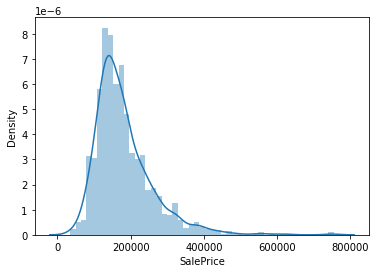

In [21]:
# The rest of the code below is just visualizations of the columns I used in my model.
# OverallQual, GarageCars, FullBath have discrete values that range from 3 to 10, or 1 to 3.
sns.distplot(df.SalePrice)
# Not normally distributed, right skewed

c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

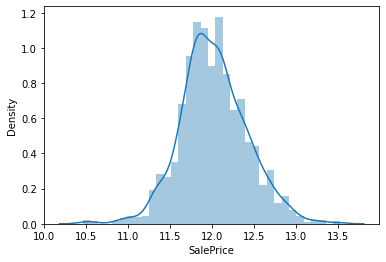

In [22]:
# log transformation, looks a bit more normal
sns.distplot(np.log(df.SalePrice))

c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GrLivArea', ylabel='Density'>

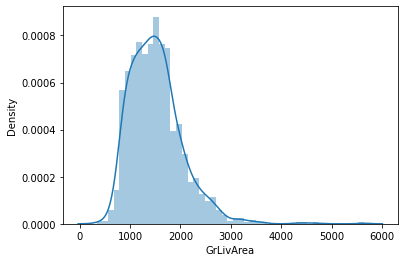

In [23]:
sns.distplot(df.GrLivArea)

NormaltestResult(statistic=4.083414046777612, pvalue=0.12980693816719516)


c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


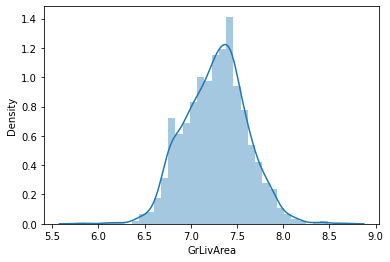

In [24]:
sns.distplot(np.log(df.GrLivArea))
print(normaltest(np.log(df.GrLivArea))) # normal test, arguably 'normal'

c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='Density'>

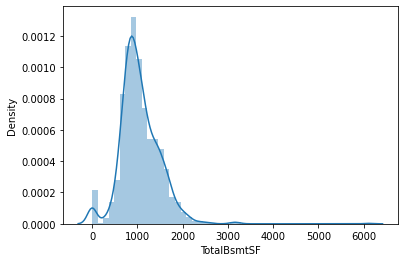

In [25]:
sns.distplot(df.TotalBsmtSF)
# not normally distributed, unable to log transform because of division by zero error

c:\Users\lowde\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='YearBuilt', ylabel='Density'>

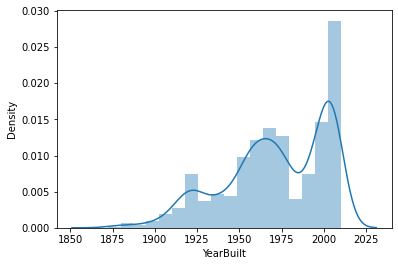

In [26]:
sns.distplot(df.YearBuilt) # nowhere near normal